In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import pyarrow.parquet

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [2]:
df_train = pd.read_parquet("00_dataset/without_stopwords/train_features_svd.parquet")
df_test = pd.read_parquet("00_dataset/without_stopwords/test_features_svd.parquet")
df_val = pd.read_parquet("00_dataset/without_stopwords/val_features_svd.parquet")

In [3]:
# Separate into X and y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

X_val = df_val.drop(columns=["label"])
y_val = df_val["label"]

In [ ]:
# Feature Scaling
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit on training data & transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform test and validation data
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Convert scaled arrays back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# Save the fitted scaler (Optional: for future use)
joblib.dump(scaler, "00_dataset/without_stopwords/minmax_scaler_svd.joblib")
print("MinMaxScaler saved successfully.")

MinMaxScaler saved successfully.


In [4]:
# Load Min Max Scaler
mms = joblib.load('00_dataset/without_stopwords/minmax_scaler_svd.joblib')
X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)
X_val_scaled = mms.transform(X_val)

In [5]:
# Check class distribution after split
print("Train Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation Class Distribution:\n", y_val.value_counts(normalize=True))
print("\nTest Class Distribution:\n", y_test.value_counts(normalize=True))

Train Class Distribution:
 label
0    0.867799
1    0.132201
Name: proportion, dtype: float64

Validation Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64

Test Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64


In [6]:
X_train_scaled

array([[0.43357685, 0.41259563, 0.14912954, ..., 0.01996528, 0.        ,
        0.02968037],
       [0.32249627, 0.33943164, 0.279144  , ..., 0.01041667, 0.        ,
        0.03144928],
       [0.32556587, 0.42764446, 0.14840883, ..., 0.0078125 , 0.        ,
        0.02684211],
       ...,
       [0.4413289 , 0.4105941 , 0.16414492, ..., 0.06597222, 0.        ,
        0.02686391],
       [0.26518422, 0.35333663, 0.24671173, ..., 0.00694444, 0.        ,
        0.02266667],
       [0.3415182 , 0.4368719 , 0.15870115, ..., 0.03645833, 0.        ,
        0.02673913]], dtype=float32)

In [7]:
print("Contains negative values:", np.any(X_train_scaled < 0))


Contains negative values: False


In [9]:
nb = MultinomialNB()
nb.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(nb, '00_dataset/without_stopwords/nb/svd_nb.joblib')
print("Naive Bayes training completed and saved.")

Naive Bayes training completed and saved.


Validation Accuracy: 0.8678

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     52802
           1       0.00      0.00      0.00      8044

    accuracy                           0.87     60846
   macro avg       0.43      0.50      0.46     60846
weighted avg       0.75      0.87      0.81     60846



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC Score:  0.662433134746885


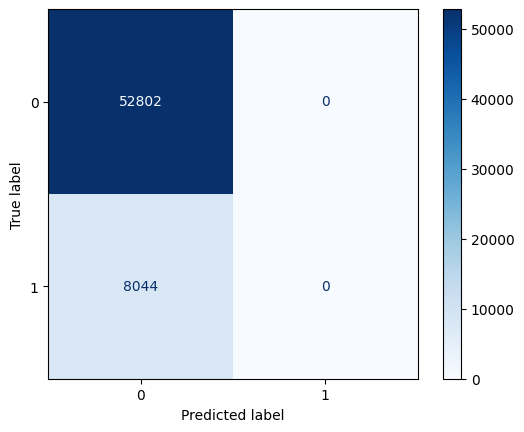

In [10]:
# Load the last saved model
nb = joblib.load('00_dataset/without_stopwords/nb/svd_nb.joblib')

# Predict on validation data
y_val_pred = nb.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

# Apply SMOTE

In [8]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [9]:
# Save SMOTE-transformed dataset
joblib.dump((X_train_smote, y_train_smote), "smoteAuto_resampled.joblib")
print("SMOTE-transformed dataset saved successfully.")

SMOTE-transformed dataset saved successfully.


In [12]:
# Check class distribution before and after SMOTE
print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_smote).value_counts())

Before SMOTE:
 label
0    369613
1     56307
Name: count, dtype: int64

After SMOTE:
 label
0    369613
1    369613
Name: count, dtype: int64


In [13]:
nbSVD_smote = MultinomialNB(class_prior=[0.5, 0.5])
nbSVD_smote.fit(X_train_smote, y_train_smote)

# Save the model
joblib.dump(nbSVD_smote, '00_dataset/without_stopwords/nb_classweights/nbSVD_smote.joblib')
print("Naive Bayes with SMOTE training completed and saved.")

Naive Bayes with SMOTE training completed and saved.


Validation Accuracy: 0.6701

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.70      0.79     52802
           1       0.19      0.45      0.26      8044

    accuracy                           0.67     60846
   macro avg       0.54      0.58      0.53     60846
weighted avg       0.80      0.67      0.72     60846

ROC-AUC Score:  0.6179879291034645


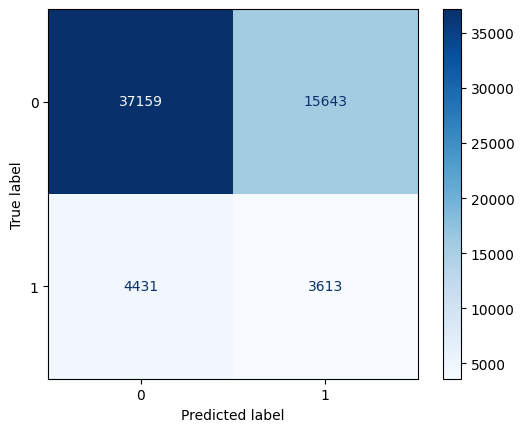

In [15]:
# Load the last saved model
nbSVD_smote = joblib.load('00_dataset/without_stopwords/nb_classweights/nbSVD_smote.joblib')

# Predict on validation data
y_val_pred = nbSVD_smote.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nbSVD_smote.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [5]:
smote75 = SMOTE(sampling_strategy=0.75, random_state=42)
X_train_smote75, y_train_smote75 = smote75.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote75, y_train_smote75), "smote75_resampled.joblib")
print("SMOTE75-transformed dataset saved successfully.")

SMOTE75-transformed dataset saved successfully.


Validation Accuracy: 0.6628

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.69      0.78     52802
           1       0.19      0.47      0.27      8044

    accuracy                           0.66     60846
   macro avg       0.54      0.58      0.52     60846
weighted avg       0.80      0.66      0.71     60846

ROC-AUC Score:  0.6192829988451645


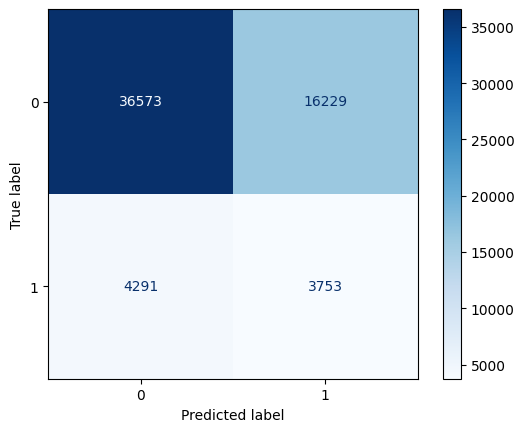

In [ ]:
nbSVD_smote75 = MultinomialNB(class_prior=[0.5, 0.5])
nbSVD_smote75.fit(X_train_smote75, y_train_smote75)

# Predict on validation data
y_val_pred = nbSVD_smote75.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nbSVD_smote75.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [10]:
smote50 = SMOTE(sampling_strategy=0.50, random_state=42)
X_train_smote50, y_train_smote50 = smote50.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote50, y_train_smote50), "smote50_resampled.joblib")
print("SMOTE50-transformed dataset saved successfully.")

SMOTE50-transformed dataset saved successfully.


Validation Accuracy: 0.6472

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77     52802
           1       0.19      0.50      0.27      8044

    accuracy                           0.65     60846
   macro avg       0.54      0.58      0.52     60846
weighted avg       0.80      0.65      0.70     60846

ROC-AUC Score:  0.6221753543081703


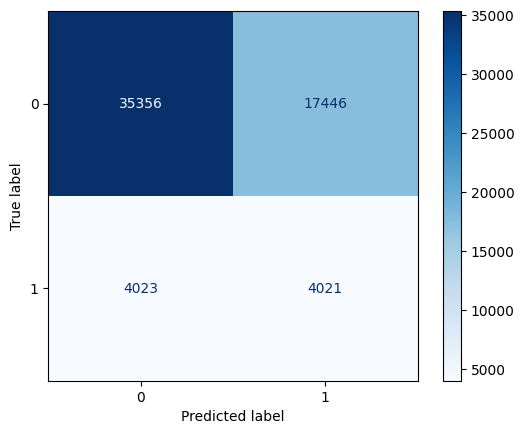

In [ ]:
nbSVD_smote50 = MultinomialNB(class_prior=[0.5, 0.5])
nbSVD_smote50.fit(X_train_smote50, y_train_smote50)

# Predict on validation data
y_val_pred = nbSVD_smote50.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nbSVD_smote50.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

Validation Accuracy: 0.6472

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77     52802
           1       0.19      0.50      0.27      8044

    accuracy                           0.65     60846
   macro avg       0.54      0.58      0.52     60846
weighted avg       0.80      0.65      0.70     60846

ROC-AUC Score:  0.6221617671497344


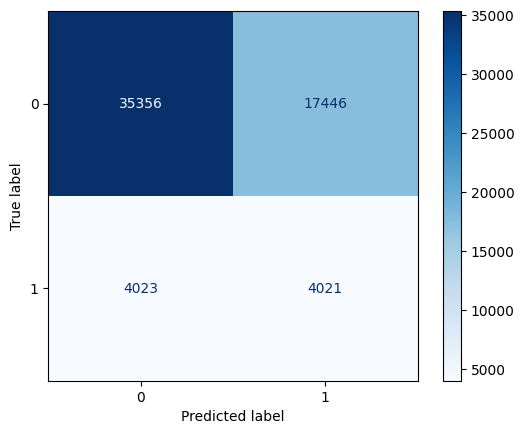

In [ ]:
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB(alpha=0.1)
cnb.fit(X_train_smote50, y_train_smote50)

# Predict on validation data
y_val_pred = cnb.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = cnb.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [7]:
smote30 = SMOTE(sampling_strategy=0.30, random_state=42)
X_train_smote30, y_train_smote30 = smote30.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote30, y_train_smote30), "smote30_resampled.joblib")
print("SMOTE30-transformed dataset saved successfully.")

SMOTE30-transformed dataset saved successfully.


In [11]:
from collections import Counter

# Check class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Check class distribution after SMOTE
print("After SMOTE:", Counter(y_train_smote30))

Before SMOTE: Counter({0: 369613, 1: 56307})
After SMOTE: Counter({0: 369613, 1: 110883})


Validation Accuracy: 0.6157

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.62      0.74     52802
           1       0.19      0.56      0.28      8044

    accuracy                           0.62     60846
   macro avg       0.54      0.59      0.51     60846
weighted avg       0.81      0.62      0.68     60846

ROC-AUC Score:  0.6293680724915657


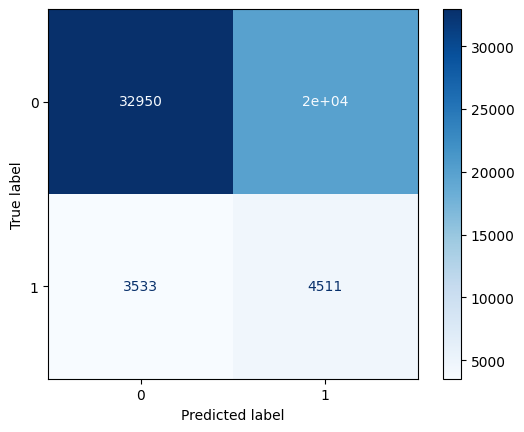

In [12]:
nbSVD_smote30 = MultinomialNB(class_prior=[0.5, 0.5])
nbSVD_smote30.fit(X_train_smote30, y_train_smote30)

# Predict on validation data
y_val_pred = nbSVD_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nbSVD_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

## Using SMOTE 30 to test out for the other models

In [5]:
from collections import Counter

# Load Smote 30
X_train_smote30, y_train_smote30 = joblib.load('smote30_resampled.joblib')

# Check class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Check class distribution after SMOTE
print("After SMOTE:", Counter(y_train_smote30))

Before SMOTE: Counter({0: 369613, 1: 56307})
After SMOTE: Counter({0: 369613, 1: 110883})


### Logistic Regression

In [11]:
# Train Logistic Regression
lr_smote30 = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga', random_state=42, n_jobs=-1)
lr_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(lr_smote30, '00_dataset/without_stopwords/lr_classweights/lr_smote30.joblib')
print("Logistic Regression with SMOTE training completed and saved.")

Logistic Regression with SMOTE training completed and saved.


Validation Accuracy: 0.7225

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.82     52802
           1       0.25      0.57      0.35      8044

    accuracy                           0.72     60846
   macro avg       0.59      0.66      0.59     60846
weighted avg       0.83      0.72      0.76     60846

ROC-AUC Score:  0.7250266203299752


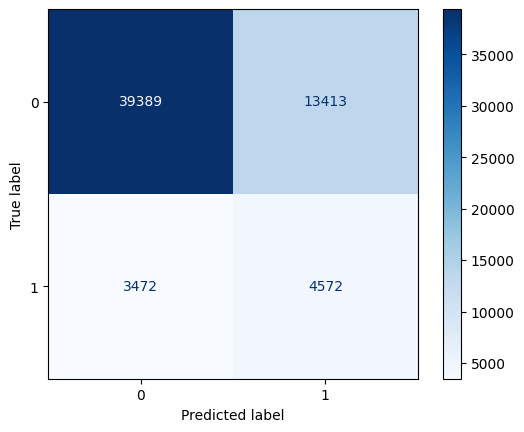

In [12]:
# Load the last saved model
# lr_smote30 = joblib.load('00_dataset/without_stopwords/lr_classweights/lr_smote30.joblib') # Replace X with the last batch number

# Predict on validation data
y_val_pred = lr_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = lr_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

### Random Forest

In [7]:
rf_smote30 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(rf_smote30, '00_dataset/without_stopwords/rf_smote30_classweights/rf_smote30.joblib')
print("Random Forest with SMOTE training completed and saved.")

Random Forest with SMOTE training completed and saved.


Validation Accuracy: 0.8669

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93     52802
           1       0.44      0.03      0.05      8044

    accuracy                           0.87     60846
   macro avg       0.66      0.51      0.49     60846
weighted avg       0.81      0.87      0.81     60846

ROC-AUC Score:  0.6582948714647749


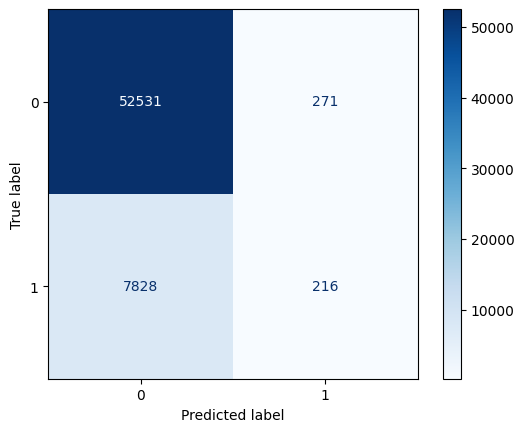

In [8]:
# Predict on validation data
y_val_pred = rf_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = rf_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

### SVM

running for over 500mins 

In [ ]:
svm_smote30 = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(svm_smote30, '00_dataset/without_stopwords/svm_classweights/svm_smote30.joblib')
print("SVM with SMOTE training completed and saved.")

In [ ]:
# Predict on validation data
y_val_pred = svm_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = svm_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

### Adaboost

running for over 700mins --> to try with another model

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
import joblib

# Train AdaBoost with SMOTE 0.3
ab_smote30 = AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
ab_smote30.fit(X_train_smote30, y_train_smote30)

# Save the model
joblib.dump(ab_smote30, '00_dataset/without_stopwords/ab_classweights/ab_smote30.joblib')
print("AdaBoost with SMOTE training completed and saved.")

c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# Predict on validation data
y_val_pred = ab_smote30.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = ab_smote30.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

# Apply SMOTE + Tomek
Adds minority samples (SMOTE) & removes noisy majority samples (Tomek)

In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42, n_jobs=-1)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote_tomek, y_train_smote_tomek), "smotetomek50_resampled.joblib")

SMOTE Tomek will be scrape as it is taking too long to compute. (> 160 mins)

In [ ]:
nb_smote_tomek = MultinomialNB(class_prior=[0.5, 0.5])
nb_smote_tomek.fit(X_train_smote_tomek, y_train_smote_tomek)

# Save the model
joblib.dump(nb_smote_tomek, '00_dataset/without_stopwords/nb_classweights/nb_smote_tomek.joblib')
print("Naive Bayes with SMOTE Tomek training completed and saved.")

In [ ]:
# Load the last saved model
nb_smote_tomek = joblib.load('00_dataset/without_stopwords/nb_classweights/nb_smote_tomek.joblib')

# Predict on validation data
y_val_pred = nb_smote_tomek.predict(X_val_scaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb_smote_tomek.predict_proba(X_val_scaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [ ]:
# Train Logistic Regression
lr_smote_tomek = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')
lr_smote_tomek.fit(X_train_smote_tomek, y_train_smote_tomek)

# Save the model
joblib.dump(lr_smote_tomek, '00_dataset/without_stopwords/lr_classweights/lr_smote_tomek.joblib')
print("Logistic Regression with SMOTE Tomek training completed and saved.")

# Apply SMOTE + ENN
SMOTE ENN will be scrape as it is taking too long to compute. (> 100 mins)

In [1]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(sampling_strategy=0.5, random_state=42, n_jobs=-1)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train_scaled, y_train)

joblib.dump((X_train_smote_enn, y_train_smote_enn), "smoteenn50_resampled.joblib")

NameError: name 'X_train_scaled' is not defined